# Image segmentation using U-Net

Image segmentation is a method of partitioning an image into segments or regions based on certain criteria, such as color, texture, edge information, or other visual features. The main goal of image segmentation is to extract meaningful information from the image, such as object boundaries or regions of interest. This information can be further analyzed or used for other applications, such as object recognition or tracking. While it is possible to assign a unique color or label to each segment for visualization purposes, this is not the primary goal of image segmentation. The technique has been used in various fields, such as medical imaging and self-driving cars, but its applications are not limited to these areas.


**U-net** is actually a specific type of neural network architecture that is commonly used for image segmentation tasks. The U-net architecture was developed for biomedical image segmentation, specifically for segmenting neuronal structures in electron microscopy images.

The U-net architecture is based on a fully convolutional network that has a contracting path to capture the context of the image and a symmetric expanding path to enable precise localization of objects. The network uses skip connections to combine low-level and high-level features, which allows for more accurate segmentation results.

The main idea of this experiment is to segment images of a street for use in a self-driving car. After segmenting the street, the driver can then know what's in the street and how to overcome the sights and any other things.

<img src="images/carseg.png" width="400"/>

## 1. Packages
 The required packets for this project

In [1]:
import tensorflow as tf
import numpy as np

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate

## 2. Load and split the dataset

In [2]:
import os
import pandas as pd

import imageio

import matplotlib.pyplot as plt
%matplotlib inline

path = ''
image_path = os.path.join(path, './data/CameraRGB/')
# print(image_path) => ./data/CameraRGB/

mask_path = os.path.join(path, './data/CameraMask/')
# print(mask_path) => ./data/CameraMask/


image_list = os.listdir(image_path)
# print(image_list) => ['000026.png', '000027.png',...] 

mask_list = os.listdir(mask_path)
# print(mask_list) => ['000026.png', '000027.png',...]

image_list = [image_path+i for i in image_list]
# print(image_list) => ['./data/CameraRGB/000026.png',...]

mask_list = [mask_path+i for i in mask_list]
# print(image_list) => ['./data/CameraMask/000026.png',...]

### Check if both lists have paths of the same image (RGB image and mask image)

Text(0.5, 1.0, 'Segmentation')

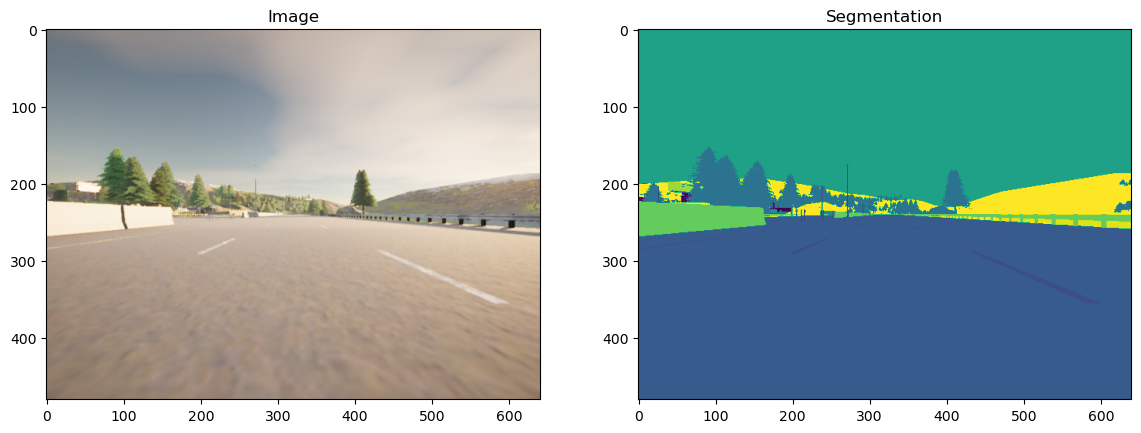

In [3]:
N = 2

rgbImage = imageio.v2.imread(image_list[N])
maskImage = imageio.v2.imread(mask_list[N])

fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(rgbImage)
arr[0].set_title('Image')
arr[1].imshow(maskImage[:, :, 0])
arr[1].set_title('Segmentation')

## 2.1 Split Your Dataset into Unmasked and Masked Images

**tf.data.Dataset.list_files()** is a method that creates a dataset of file paths from a list of file patterns. 

In [4]:
image_list_ds = tf.data.Dataset.list_files(image_list, shuffle=False)
mask_list_ds = tf.data.Dataset.list_files(mask_list, shuffle=False)

The shuffle parameter is set to **False**, so the order of files in the dataset will be deterministic and follow the order of file paths in the original lists.

In [5]:
image_list_ds = tf.data.Dataset.list_files(image_list, shuffle=False)
mask_list_ds = tf.data.Dataset.list_files(mask_list, shuffle=False)

In [8]:
image_filenames = tf.constant(image_list)
masks_filenames = tf.constant(mask_list)

**tf.data.Dataset.from_tensor_slices()** is a method in TensorFlow that creates a dataset from one or more tensors. In this case, it creates a dataset by combining two tensors **image_filenames** and **masks_filenames** as slices, such that each pair of corresponding elements from the two tensors forms an element of the resulting dataset.

In [10]:
dataset = tf.data.Dataset.from_tensor_slices((image_filenames, masks_filenames))

* dataset.take(1) returns a new dataset that contains only the first element of the original dataset. 
* dataset.take(3) would return a new dataset that contains the first three elements of the original dataset, in the same order they appeared in the original dataset.

In [16]:
for image, mask in dataset.take(1):
    print(image)
    print(mask)

tf.Tensor(b'./data/CameraRGB/000026.png', shape=(), dtype=string)
tf.Tensor(b'./data/CameraMask/000026.png', shape=(), dtype=string)


### 2.1 Preprocess Your Data

Normally, you normalize your image values by dividing them by `255`. This sets them between `0` and `1`. However, using `tf.image.convert_image_dtype` with `tf.float32` sets them between `0` and `1` for you, so there's no need to further divide them by `255`.

* `tf.io.read_file` reads the contents of a file.
* `tf.image.decode_png` decodes a PNG-encoded image into a tensor.
* `tf.image.convert_image_dtype` converts the image tensor into a float32 tensor with values between 0 and 1.
* `tf.math.reduce_max` reduces the mask tensor along the last dimension (the channel dimension) and keeps only the maximum value, resulting in a 2D mask tensor with 0s and 1s.


In [18]:
def process_path(image_path, mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    return img, mask

def preprocess(image, mask):
    input_image = tf.image.resize(image, (96, 128), method='nearest')
    input_mask = tf.image.resize(mask, (96, 128), method='nearest')

    return input_image, input_mask

image_ds = dataset.map(process_path)
processed_image_ds = image_ds.map(preprocess)

## 3. U-Net artichecute 

The U-Net architecture is named after its U-shape, which consists of a contracting path followed by an expanding path. It is a type of fully convolutional network that is commonly used for image segmentation tasks in deep learning.

Unlike traditional convolutional networks that use max pooling and stride to reduce the feature maps' spatial resolution, U-Net uses convolutional layers to downsample the input image and then upsamples it to the original size using transposed convolutional layers. This approach preserves the spatial information and helps to produce more accurate segmentation results.

Additionally, U-Net uses skip connections, which are connections between the encoder and decoder layers that transfer the low-level features from the contracting path to the expanding path. These skip connections help to maintain the spatial information and prevent the loss of important details during the upsampling process.

<img src="images/unet.png" width="600"/>

**A. Contracting path (Encoder containing downsampling steps):**

Images are first fed through several convolutional layers which reduce height and width, while growing the number of channels. The contracting path follows a regular CNN architecture, with convolutional layers, their activations, and pooling layers to downsample the image and extract its features. In detail, it consists of the repeated application of two 3 x 3 valid padding convolutions, each followed by a rectified linear unit (ReLU) and a 2 x 2 max pooling operation with stride 2 for downsampling. At each downsampling step, the number of feature channels is doubled.

**B. Crop function:**

This step crops the image from the contracting path and concatenates it to the current image on the expanding path to create a skip connection.

**C. Expanding path (Decoder containing upsampling steps):**

The expanding path performs the opposite operation of the contracting path, growing the image back to its original size, while shrinking the channels gradually.

In detail, each step in the expanding path upsamples the feature map, followed by a 2 x 2 convolution (the transposed convolution). This transposed convolution halves the number of feature channels, while growing the height and width of the image.

Next is a concatenation with the correspondingly cropped feature map from the contracting path, and two 3 x 3 convolutions, each followed by a ReLU. You need to perform cropping to handle the loss of border pixels in every convolution.

### 3.1 Encoder (Downsampling Block)

In this step, we will create a U-Net encoder part, which will consist of multiple convolution layers followed by multiple max pooling, dropout, and so on. fro the architecture we can note that consist of two conv follow by max pooling and so on.

<img src="images/encoder.png" width="500"/>

In [19]:
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
    """
    Convolutional downsampling block
    
    Arguments:
        inputs -- Input tensor
        n_filters -- Number of filters for the convolutional layers
        dropout_prob -- Dropout probability
        max_pooling -- Use MaxPooling2D to reduce the spatial dimensions of the output volume
    Returns: 
        next_layer, skip_connection --  Next layer and skip connection outputs
    """

    
    conv = Conv2D(n_filters, # Number of filters
                  3,   # Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(inputs)
    conv = Conv2D(n_filters, # Number of filters
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(conv)
    
    
    # if dropout_prob > 0 add a dropout layer, with the variable dropout_prob as parameter
    if dropout_prob > 0:
         
        conv = Dropout(dropout_prob)(conv)
         
         
        
    # if max_pooling is True add a MaxPooling2D with 2x2 pool_size
    if max_pooling:
        
        next_layer = MaxPooling2D()(conv)
        
        
    else:
        next_layer = conv
        
    skip_connection = conv
    
    return next_layer, skip_connection

### 3.1 Decoder (Upsampling Block)

Implement `upsampling_block(...)`.

For the function `upsampling_block`: 
* Takes the arguments `expansive_input` (which is the input tensor from the previous layer) and `contractive_input` (the input tensor from the previous skip layer)
* The number of filters here is the same as in the downsampling block you completed previously
* Your `Conv2DTranspose` layer will take `n_filters` with shape (3,3) and a stride of (2,2), with padding set to `same`. It's applied to `expansive_input`, or the input tensor from the previous layer. 

This block is also where you'll concatenate the outputs from the encoder blocks, creating skip connections. 

* Concatenate your Conv2DTranspose layer output to the contractive input, with an `axis` of 3. In general, you can concatenate the tensors in the order that you prefer. But for the grader, it is important that you use `[up, contractive_input]`

For the final component, set the parameters for two Conv2D layers to the same values that you set for the two Conv2D layers in the encoder (ReLU activation, He normal initializer, `same` padding). 


In [20]:
def upsampling_block(expansive_input, contractive_input, n_filters=32):
    """
    Convolutional upsampling block
    
    Arguments:
        expansive_input -- Input tensor from previous layer
        contractive_input -- Input tensor from previous skip layer
        n_filters -- Number of filters for the convolutional layers
    Returns: 
        conv -- Tensor output
    """
    
    ### START CODE HERE
    up = Conv2DTranspose(
                 n_filters,    # number of filters
                 3,    # Kernel size
                 strides=(2,2),
                 padding='same')(expansive_input)
    
    # Merge the previous output and the contractive_input
    merge = concatenate([up, contractive_input], axis=3)
    conv = Conv2D(n_filters,   # Number of filters
                 3,     # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(merge)
    conv = Conv2D(n_filters,  # Number of filters
                 3,   # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(conv)
    ### END CODE HERE
    
    return conv

## 3.4 Build the Model

This is where you'll put it all together, by chaining the encoder, bottleneck, and decoder! You'll need to specify the number of output channels, which for this particular set would be 23. That's because there are 23 possible labels for each pixel in this self-driving car dataset.


**unet_model**

For the function `unet_model`, specify the input shape, number of filters, and number of classes (23 in this case).

For the first half of the model:

* Begin with a conv block that takes the inputs of the model and the number of filters
* Then, chain the first output element of each block to the input of the next convolutional block
* Next, double the number of filters at each step
* Beginning with `conv_block4`, add `dropout_prob` of 0.3
* For the final conv_block, set `dropout_prob` to 0.3 again, and turn off max pooling  

For the second half:

* Use cblock5 as expansive_input and cblock4 as contractive_input, with `n_filters` * 8. This is your bottleneck layer. 
* Chain the output of the previous block as expansive_input and the corresponding contractive block output.
* Note that you must use the second element of the contractive block before the max pooling layer. 
* At each step, use half the number of filters of the previous block
* `conv9` is a Conv2D layer with ReLU activation, He normal initializer, `same` padding
* Finally, `conv10` is a Conv2D that takes the number of classes as the filter, a kernel size of 1, and "same" padding. The output of `conv10` is the output of your model. 

In [21]:
def unet_model(input_size=(96, 128, 3), n_filters=32, n_classes=23):
    """
    Unet model
    
    Arguments:
        input_size -- Input shape 
        n_filters -- Number of filters for the convolutional layers
        n_classes -- Number of output classes
    Returns: 
        model -- tf.keras.Model
    """
    inputs = Input(input_size)
    # Contracting Path (encoding)
    # Add a conv_block with the inputs of the unet_ model and n_filters
   
    cblock1 = conv_block(inputs, n_filters)
    # Chain the first element of the output of each block to be the input of the next conv_block. 
    # Double the number of filters at each new step
    cblock2 = conv_block(cblock1[0], n_filters * 2)
    cblock3 = conv_block(cblock2[0], n_filters * 4)
    cblock4 = conv_block(cblock3[0], n_filters * 8, dropout_prob=0.3) # Include a dropout_prob of 0.3 for this layer
    # Include a dropout_prob of 0.3 for this layer, and avoid the max_pooling layer
    cblock5 = conv_block(cblock4[0], n_filters * 16, dropout_prob=0.3, max_pooling=False) 
    
    
    # Expanding Path (decoding)
    # Add the first upsampling_block.
    # Use the cblock5[0] as expansive_input and cblock4[1] as contractive_input and n_filters * 8
    
    ublock6 = upsampling_block(cblock5[0], cblock4[1],  n_filters * 8)
    # Chain the output of the previous block as expansive_input and the corresponding contractive block output.
    # Note that you must use the second element of the contractive block i.e before the maxpooling layer. 
    # At each step, use half the number of filters of the previous block 
    ublock7 = upsampling_block(ublock6, cblock3[1],  n_filters * 4)
    ublock8 = upsampling_block(ublock7, cblock2[1],  n_filters * 2)
    ublock9 = upsampling_block(ublock8, cblock1[1],  n_filters)

    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)

    # Add a Conv2D layer with n_classes filter, kernel size of 1 and a 'same' padding
    conv10 = Conv2D(n_classes, 1, padding='same')(conv9)
    
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

In [22]:
img_height = 96
img_width = 128
num_channels = 3

unet = unet_model((img_height, img_width, num_channels))

In [23]:
unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 128, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 96, 128, 32)  896         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 96, 128, 32)  9248        ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 48, 64, 32)   0           ['conv2d_1[0][0]']           

Total params: 8,640,471
Trainable params: 8,640,471
Non-trainable params: 0
__________________________________________________________________________________________________


### 3.5 Loss Function

SparseCategoricalCrossentropy is a loss function used in deep learning for multi-class classification problems where the classes are mutually exclusive.

In contrast to the CategoricalCrossentropy loss function, which expects the targets to be in one-hot encoded format (i.e., a vector of 0s and a single 1 indicating the correct class), the SparseCategoricalCrossentropy function can handle integer target values, where each integer represents the index of the correct class.

The function computes the cross-entropy loss between the predicted class probabilities and the true class labels. The output of the function is a scalar value that represents the average loss over all samples in the batch.

The SparseCategoricalCrossentropy loss function is commonly used in deep learning frameworks like TensorFlow and Keras. It is particularly useful when dealing with large datasets, where one-hot encoding can be memory-intensive and computationally expensive.

In [24]:
unet.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Training 
* **EPOCHS = 5:** This sets the number of epochs (i.e., complete passes through the training data) for the training process. In this case, the model will be trained for 5 epochs.

* **VAL_SUBSPLITS = 5:** This is the number of times to split the validation data. This is useful when the validation data is too large to fit into memory all at once.

* **BUFFER_SIZE = 500:** This is the number of samples to use for shuffling the training dataset. It determines how many samples are loaded into memory at once during the training process.

* **BATCH_SIZE = 32:** This is the number of samples to use for each training batch. A batch is a subset of the training data that is used to update the model's weights during each training iteration.

* **train_dataset = processed_image_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE):** This creates a TensorFlow dataset object for the training data. The dataset is first cached in memory to speed up subsequent processing, then shuffled, and finally batched using the specified batch size.

In [25]:
EPOCHS = 5
VAL_SUBSPLITS = 5
BUFFER_SIZE = 500
BATCH_SIZE = 32
train_dataset = processed_image_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(processed_image_ds.element_spec)
model_history = unet.fit(train_dataset, epochs=EPOCHS)

(TensorSpec(shape=(96, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(96, 128, 1), dtype=tf.uint8, name=None))
Epoch 1/5
34/34 [==============================] - 261s 7s/step - loss: 2.0588 - accuracy: 0.4154
Epoch 2/5
34/34 [==============================] - 240s 7s/step - loss: 1.0462 - accuracy: 0.7168
Epoch 3/5
34/34 [==============================] - 240s 7s/step - loss: 0.5925 - accuracy: 0.8313
Epoch 4/5
34/34 [==============================] - 238s 7s/step - loss: 0.4837 - accuracy: 0.8653
Epoch 5/5
34/34 [==============================] - 238s 7s/step - loss: 0.4121 - accuracy: 0.8801


In [35]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

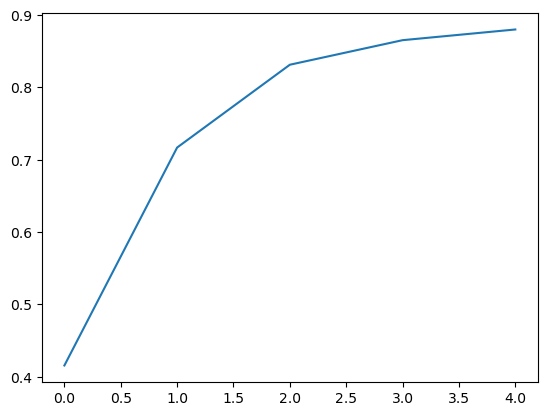

In [36]:
plt.plot(model_history.history["accuracy"])

In [37]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

In [38]:
def show_predictions(dataset=None, num=1):
    """
    Displays the first image of each of the num batches
    """
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = unet.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(unet.predict(sample_image[tf.newaxis, ...]))])

1/1 [==============================] - 2s 2s/step


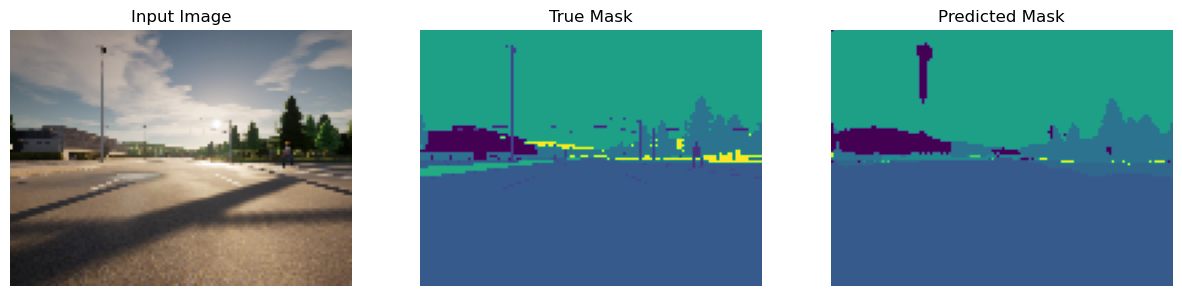

1/1 [==============================] - 2s 2s/step


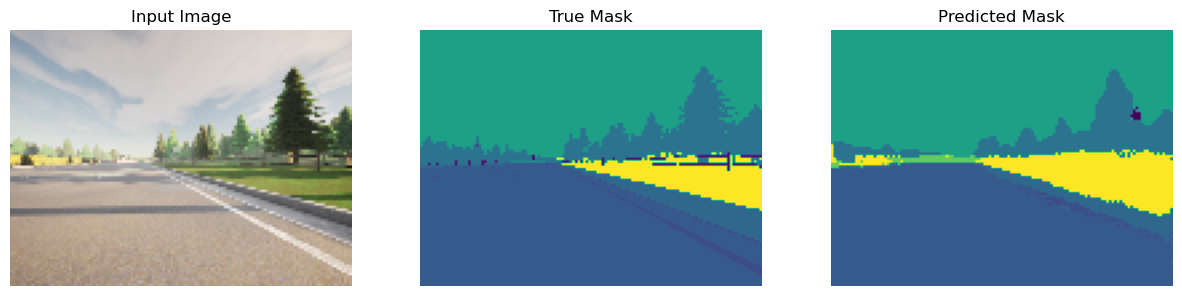

In [39]:
show_predictions(train_dataset, 2)

# Test the model 

1/1 [==============================] - 0s 109ms/step


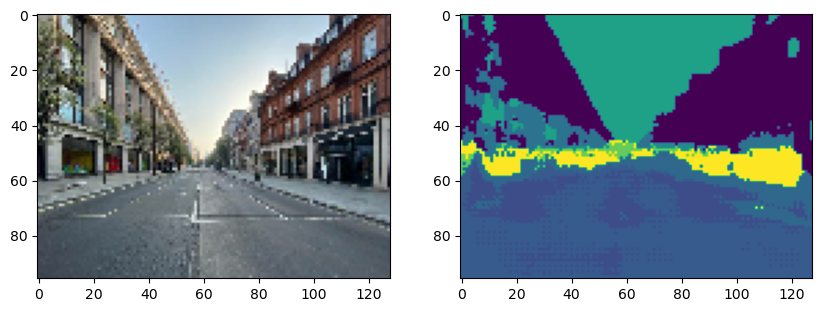

In [114]:
def process_path(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, (96, 128), method='nearest')
    return img

img = process_path('images/test2.jpg')
img = tf.reshape(img, (1, 96, 128, 3))

mask_pred = unet.predict(img)

predictedMask = create_mask(mask_pred)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img[0])
ax[1].imshow(predictedMask)
plt.show()
